Purpose of notebook is to scrape web data on financial asset prices and run a mean-variance optimisation framework to target a specific risk-return profile

Import relevant libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Construct URL Generator for given set of securities to import price data

In [2]:
#Provide a dictionary with names and yahoo symbols for securities in portfolio

securities_dictionary ={'E-Mini S&P 500 Sep 20':'ES=F',
                       'E-mini Russell 2000 Index Futur' : 'RTY=F',
                       'U.S. Treasury Bond Futures' : 'ZB=F'}

#Specify frequency of data download eg. daily = '1d' /monthly = '1mo' /weekly = '1wk'

frequency ='1d'

#Specify time window to download data eg. last 30 days and annualisation factor for days

lookback = 60
ann_factor = 260

#Generates epoch timestamps to construct URL

today_date = dt.datetime(dt.datetime.now().year, dt.datetime.now().month, dt.datetime.now().day,1,0,0)
start_date = today_date - dt.timedelta(days=lookback)

today_date_string = str(round(today_date.timestamp()))
start_date_string = str(round(start_date.timestamp()))

#Creates URL dictionary mapping security names to corresponding URL downloads

url_dictionary = {}

for security in securities_dictionary.keys():
    url ='https://query1.finance.yahoo.com/v7/finance/download/'\
         +securities_dictionary[security]+\
         '?period1='+start_date_string\
         +'&period2='+today_date_string\
         +'&interval='+frequency\
         +'&events=history'
    url_dictionary[security] = url


#Display URL dictionary for debugging purposes    
display(url_dictionary)


{'E-Mini S&P 500 Sep 20': 'https://query1.finance.yahoo.com/v7/finance/download/ES=F?period1=1589155200&period2=1594339200&interval=1d&events=history',
 'E-mini Russell 2000 Index Futur': 'https://query1.finance.yahoo.com/v7/finance/download/RTY=F?period1=1589155200&period2=1594339200&interval=1d&events=history',
 'U.S. Treasury Bond Futures': 'https://query1.finance.yahoo.com/v7/finance/download/ZB=F?period1=1589155200&period2=1594339200&interval=1d&events=history'}

In [8]:
#Download web data from URL dictionary and store in a dataframe
#Creates a dictionary of dataframes

securities_price_dictionary = {}

for security in url_dictionary.keys():
    #Construct dictionary of dataframes
    
    securities_price_dictionary[security]=pd.read_csv(url_dictionary[security])
    #Select only columns of interest in each dataframe
    
    securities_price_dictionary[security] = securities_price_dictionary[security][['Date', 'Adj Close']]
    #Relabel columns in each dataframe
    
    securities_price_dictionary[security].columns = ['Date', security+' price level']
    #Set dates in each dataframe to Datetime objects
    
    securities_price_dictionary[security]['Date'] = pd.to_datetime(securities_price_dictionary[security]['Date'])

#Generate a dataframe of dataframes for every individual security

securities_price_df = pd.concat(securities_price_dictionary, axis=1)

#Flatten dataframe of security prices into a single object

iterator = iter(securities_price_df.columns.levels[0])
first_dataframe = next(iterator)
securities_price_df_flat = securities_price_df[first_dataframe]

while True:
    try:
        securities_price_df_flat = pd.merge(securities_price_df_flat, securities_price_df[next(iterator)], on = 'Date')
    except:
        break
    

#Create a dataframe of returns by filtering flat dataframe of pricing data

securities_return_df = securities_price_df_flat.iloc[:,1:].pct_change(fill_method='ffill')
securities_return_df = securities_return_df.set_index(securities_price_df_flat['Date']).dropna()

col_names = []
for position in range(len(securities_return_df.columns)):
    col_names.append(securities_return_df.columns[position].strip('price level') + ' return')

securities_return_df.columns = col_names

#Print flattened prices  and returns dataframes for debugging purposes

display(securities_price_df_flat.tail())

display(securities_return_df.tail())



,Date,E-Mini S&P 500 Sep 20 price level,E-mini Russell 2000 Index Futur price level,U.S. Treasury Bond Futures price level
45,2020-07-05,3134.25,1436.699951,178.31250
46,2020-07-06,3176.75,1445.699951,178.00000
47,2020-07-07,3141.00,1414.099976,179.09375
48,2020-07-08,3168.25,1425.800049,178.68750
49,2020-07-09,3150.75,1400.599976,180.09375


,E-Mini S&P 500 Sep 20 return,E-mini Russell 2000 Index Futu return,U.S. Treasury Bond Futures return
Date,,,
2020-07-05,0.001518,0.002582,-0.000876
2020-07-06,0.013560,0.006264,-0.001753
2020-07-07,-0.011254,-0.021858,0.006145
2020-07-08,0.008676,0.008274,-0.002268
2020-07-09,-0.005524,-0.017674,0.007870


In [48]:
#Calculate a dataframe of return and volatility to use as input to optimiser

optimiser_return_inputs_list = []
optimiser_volatility_inputs_list = []

for security in securities_return_df.columns:
    optimiser_return_inputs_list.append((1+securities_return_df[security]).cumprod()[-1]**(ann_factor/len(securities_return_df))-1)
    optimiser_volatility_inputs_list.append(securities_return_df[security].std()*np.sqrt(ann_factor))

optimiser_inputs_df = pd.DataFrame(zip(optimiser_return_inputs_list, optimiser_volatility_inputs_list))

optimiser_inputs_df.columns = ['Annualised Return', 'Annualised Volatility']
optimiser_inputs_df.index = securities_price_df.columns.levels[0]
display(optimiser_inputs_df)

#Compute covariance matrix
cov_matrix = securities_return_df.cov()*ann_factor

display(cov_matrix)

#Compute portfolio return

np.random.seed(20)
weights = np.random.random(3)
weights/=np.sum(weights)

portfolio_return = np.dot(weights, optimiser_inputs_df['Annualised Return'])

print('Portfolio return is ', '{0:.2%}'.format(portfolio_return))

portfolio_vol = np.sqrt(np.dot(weights.transpose(), np.dot(cov_matrix, weights)))

print('Portfolio volatility is ', '{0:.2%}'.format(portfolio_vol))


,Annualised Return,Annualised Volatility
E-Mini S&P 500 Sep 20,0.510145,0.236481
E-mini Russell 2000 Index Futur,0.416746,0.379669
U.S. Treasury Bond Futures,0.038611,0.080486


,E-Mini S&P 500 Sep 20 return,E-mini Russell 2000 Index Futu return,U.S. Treasury Bond Futures return
E-Mini S&P 500 Sep 20 return,0.055923,0.082460,-0.013075
E-mini Russell 2000 Index Futu return,0.082460,0.144149,-0.022076
U.S. Treasury Bond Futures return,-0.013075,-0.022076,0.006478


Portfolio return is  29.80%
Portfolio volatility is  17.78%


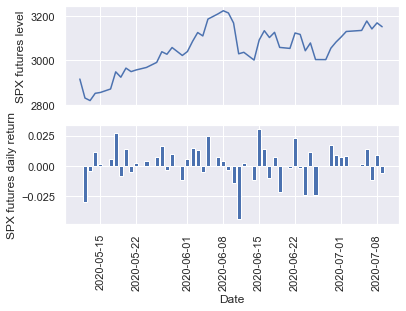

In [21]:
#Plot dataframe to check 

fig, ax = plt.subplots(2, sharex=True)
sns.set()

ax[0].plot('Date', 'E-Mini S&P 500 Sep 20 price level', data=securities_price_df_flat)
ax[0].set_ylabel('SPX futures level')


ax[1].bar(securities_return_df.index, 'E-Mini S&P 500 Sep 20 return', data=securities_return_df)
ax[1].set_ylabel('SPX futures daily return')
ax[1].set_xlabel('Date')

plt.xticks(rotation=90)
plt.show()
